<a href="https://colab.research.google.com/github/benvictoria21/python-machine-learning/blob/master/Practical_Deep_Learning_Book_chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1-predict-class.ipynb

In [6]:
try:
  import google.colab
  IS_COLAB_ENV = True
except:
  IS_COLAB_ENV = False
IS_COLAB_ENV

True

In [7]:
if IS_COLAB_ENV:
    !pip install tensorflow==2.0.0

In [8]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

In [9]:
IMG_PATH = '../../sample-images/cat.jpg'
if IS_COLAB_ENV:
  !curl https://raw.githubusercontent.com/PracticalDL/Practical-Deep-Learning-Book/master/sample-images/cat.jpg --output cat.jpg
  IMG_PATH = 'cat.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  661k  100  661k    0     0  3635k      0 --:--:-- --:--:-- --:--:-- 3635k


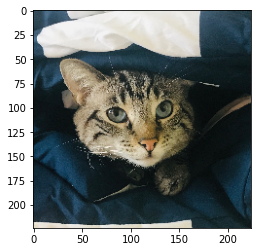

In [10]:
img = image.load_img(IMG_PATH, target_size=(224, 224))
plt.imshow(img)
plt.show()

In [11]:
model = tf.keras.applications.resnet50.ResNet50()

In [12]:
def predict(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    model = tf.keras.applications.resnet50.ResNet50()
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    prediction = model.predict(img_preprocessed)
    print(decode_predictions(prediction, top=3)[0])

In [13]:
predict(IMG_PATH)

[('n02123045', 'tabby', 0.5681726), ('n02124075', 'Egyptian_cat', 0.22223175), ('n02123159', 'tiger_cat', 0.061033934)]


2-colab-what-does-my-neural-network-think.ipynb

In [14]:
try:
  import google.colab
  IS_COLAB_ENV = True
except:
  IS_COLAB_ENV = False
  print("Please execute the non-Colab version of this notebook.")
IS_COLAB_ENV

True

In [15]:
!pip install tensorflow==2.0.0
!pip install tf-explain==0.1.0
!pip install -U pillow

Requirement already up-to-date: pillow in /usr/local/lib/python3.6/dist-packages (7.2.0)


In [16]:
!curl https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json --output imagenet_class_index.json
!curl https://raw.githubusercontent.com/PracticalDL/Practical-Deep-Learning-Book/master/sample-images/dog.jpg --output dog.jpg
!curl https://raw.githubusercontent.com/PracticalDL/Practical-Deep-Learning-Book/master/sample-images/cat.jpg --output cat.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35363  100 35363    0     0   375k      0 --:--:-- --:--:-- --:--:--  375k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2231k  100 2231k    0     0  7464k      0 --:--:-- --:--:-- --:--:-- 7464k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  661k  100  661k    0     0  3737k      0 --:--:-- --:--:-- --:--:-- 3737k


In [17]:
import numpy as np
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import get_file
import json

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tf_explain.core.grad_cam import GradCAM

import PIL
from PIL import Image, ImageDraw, ImageFont

import matplotlib.cm as cm

from argparse import ArgumentParser

import glob
import os

CLASS_INDEX = None
CLASS_INDEX_PATH = 'imagenet_class_index.json'

# Note: decode_predictions(preds, top) is originally a keras function.
# We have modified it here so that it returns the index of the class label along with the predictions.
# The results are assimilated based on the assumption that there is only one top 1% prediction.

def decode_predictions_modified(preds, top=1):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError(
            '`decode_predictions` expects ' 'a batch of predictions ''(i.e. a 2D array of shape (samples, 1000)). ' 'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        CLASS_INDEX = json.load(open(CLASS_INDEX_PATH))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        for i in top_indices:
            results = [i, tuple(CLASS_INDEX[str(i)]), (pred[i],)]
    return results

# Function that takes an image and model and produces the predictions

def get_predictions(img, model):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return decode_predictions_modified(preds, top=1)

# NOTE: These two functions are taken from Shao-Chuan Wang <shaochuan.wang AT gmail.com> 
# as per the copyright on http://code.activestate.com/recipes/577591-conversion-of-pil-image-and-numpy-array/

"""
   Copyright 2011 Shao-Chuan Wang <shaochuan.wang AT gmail.com>

    Permission is hereby granted, free of charge, to any person obtaining a copy
    of this software and associated documentation files (the "Software"), to deal
    in the Software without restriction, including without limitation the rights
    to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
    copies of the Software, and to permit persons to whom the Software is
    furnished to do so, subject to the following conditions:

    The above copyright notice and this permission notice shall be included in
    all copies or substantial portions of the Software.

    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
    IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
    FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
    AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
    LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
    OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
    THE SOFTWARE.
"""
# Modified from the original format to take only the array as input and calculate the size on the fly
def array_to_PIL(arr):
    mode = 'RGBA'
    # Use only the height and width for further processing
    size = (arr.shape[0], arr.shape[1])  # (224,224)
    arr = arr.reshape(arr.shape[0]*arr.shape[1], arr.shape[2])
    if len(arr[0]) == 3:
        arr = np.c_[arr, 255*np.ones((len(arr), 1), np.uint8)]
    return Image.frombuffer(mode, size, arr.tostring(), 'raw', mode, 0, 1)

# Function that puts text based prediction and class name on top of the image
def overlay_prediction_on_image(img, prediction_class, prediction_probability, width, height):
    img = img.resize((width, height), Image.ANTIALIAS)
    draw = ImageDraw.Draw(img)
    l = len(prediction_class)
    # Place a black rectangle to provide a background for the text
    # The size of the rectangle should change with respect to the image
    draw.rectangle([int(width*0.05), int(width*0.05),
                    int(width*0.5), int(width*0.11)], fill=(0, 0, 0))
    draw.text((int(width*0.06), int(width*0.06)), '{0:.0f}'.format(
        prediction_probability) + "% " + prediction_class, fill=(255, 255, 255))
    return img

# Based on StackOverflow code by user DTing
# https://stackoverflow.com/questions/30227466/combine-several-images-horizontally-with-python

def join_images(img1, img2):
    widths, heights = zip(*(i.size for i in [img1, img2]))
    total_width = sum(widths)
    max_height = max(heights)
    new_img = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for img in [img1, img2]:
        new_img.paste(img, (x_offset, 0))
        x_offset += img.size[0]
    return new_img

def process_image(image_path, output_path):
    model = VGG16(weights='imagenet', include_top=True, input_tensor=None, input_shape=None, pooling=None, classes=1000)
    explainer = GradCAM()

    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    data = ([img], None)

    original_image = Image.open(image_path)
    width = int(original_image.size[0]/4)
    height = int(original_image.size[1]/4)
    original_image.thumbnail((width, height), Image.ANTIALIAS)

    class_index, class_name, prob_value = get_predictions(img, model)
    heatmap = explainer.explain(data, model, "block5_conv3", class_index)

    # overlay the text prediction on the heatmap overlay
    heatmap_with_prediction_overlayed = overlay_prediction_on_image(
        array_to_PIL(heatmap), class_name[-1], prob_value[0] * 100, width, height)

    # place the images side by side
    joined_image = join_images(
        original_image, heatmap_with_prediction_overlayed)
    joined_image.save(output_path)

In [18]:
process_image("dog.jpg", "dog_output.jpg")
process_image("cat.jpg", "cat_output.jpg")

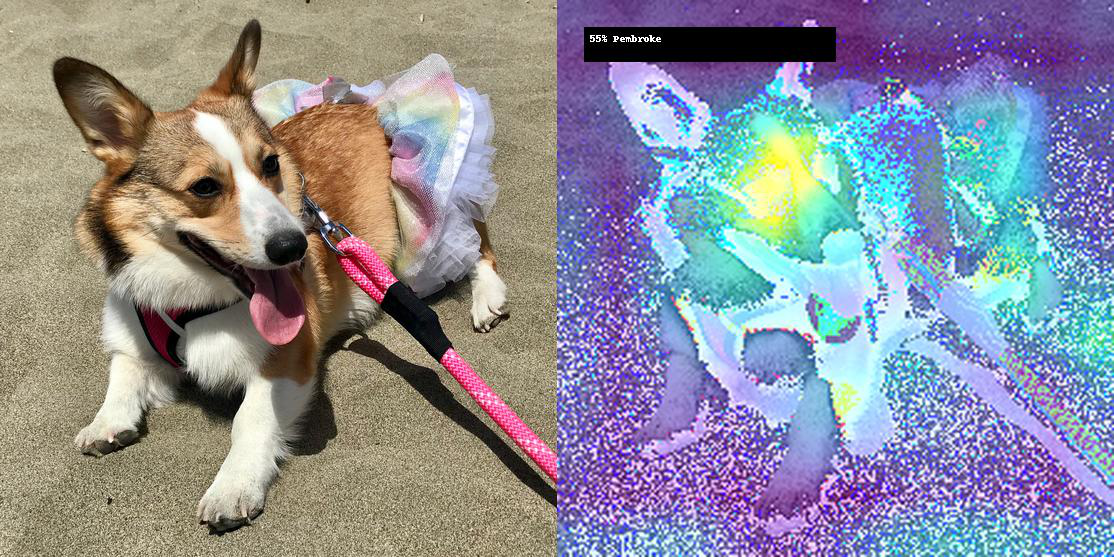

In [19]:
Image.open('dog_output.jpg')

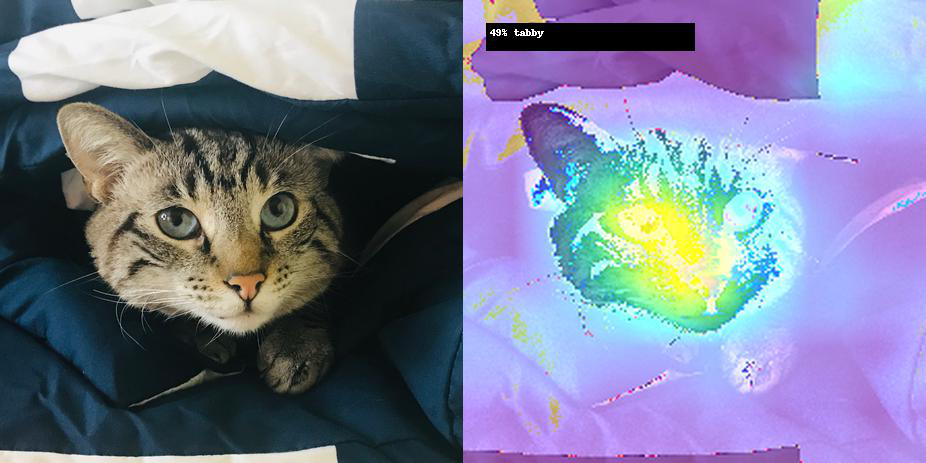

In [20]:
Image.open('cat_output.jpg')

2-what-does-my-neural-network-think.ipynb


In [20]:
!python visualization.py --process image --path ../../sample-images/dog.jpg

In [20]:
!mkdir kitchen

In [23]:
!ffmpeg -framerate 25 -i data/kitchen_output/result-%04d.jpg kitchen-output.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [24]:
!python visualization.py --process video --path data/kitchen/

python3: can't open file 'visualization.py': [Errno 2] No such file or directory
